In [151]:
import os
import torch
import pandas as pd
from skimage import io, transform
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, datasets
import random
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [152]:
df = pd.read_csv('annotations/annotations.csv')
classes = df['class1'].unique()

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [154]:
class FacetDataset(Dataset):
    """Facet dataset."""

    def __init__(self, csv_file, root_dir, transform=None, target_transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.attributes_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.attributes_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.attributes_frame.iloc[idx, 2])
        image = io.imread(img_name)
        attributes = self.attributes_frame.iloc[idx, 3:]
        attributes = np.array([attributes]).reshape(-1, 1)
        
        label = class_to_idx[self.attributes_frame.iloc[idx, 3]]
        #don't index to get all attributes
        sample = {'image': image, 'attributes': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (1500, 2000, 3) 0


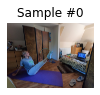

1 (1500, 2250, 3) 1


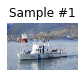

2 (1500, 2250, 3) 2


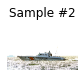

3 (1500, 2247, 3) 3


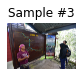

In [156]:
face_dataset = FacetDataset(csv_file='annotations/annotations.csv',
                                    root_dir='.')

fig = plt.figure()

for i, sample in enumerate(face_dataset):
    print(i, sample['image'].shape, sample['attributes'])

    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(sample['image'])
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.show()
    if i == 3:
        break

In [208]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, attributes = sample['image'], sample['attributes']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for attributes because for images,
        # x and y axes are axis 1 and 0 respectively

        return {'image': img, 'attributes': attributes}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, attributes = sample['image'], sample['attributes']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'attributes': attributes}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, attributes = sample['image'].astype(np.float32), sample['attributes']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image), torch.tensor(attributes)

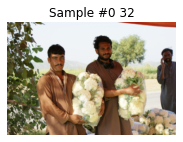

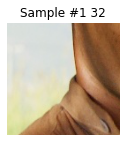

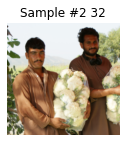

In [209]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure(figsize=(8, 8))  
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(transformed_sample['image'])
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i) + ' ' + str(sample['attributes']))
    ax.axis('off')
    plt.show()

plt.show()

In [210]:
transformed_dataset = FacetDataset(csv_file='annotations/annotations.csv',
                                    root_dir='.',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

In [211]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)

In [212]:
# Step 1: Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)

# Step 2: Replace the final fully connected layer for your specific classification task
num_classes = 10  # Replace with the number of classes in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Step 3: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [213]:
num_epochs = 10  # Adjust as needed
device = torch.device('mps')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f}')

print('Finished fine-tuning.')